In [1]:
import json
from collections import defaultdict
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

def parse_tab(bench_col):
    tabs = {}
    for name, impls in bench_col.items():
        xs = []
        ys = []
        yerr = []
        for label, impl in impls.items():
            nda = np.array(impl, dtype=np.float64) / 1000
            xs.append(int(label))
            ys.append(nda.mean())
            yerr.append(nda.std())
        tabs[name] = {
            'x': xs,
            'y': ys,
            'yerr': yerr,
        }
    return tabs

In [2]:
results = Path('output.files/results')
qty = 1000000

tabs = {}
for fn in ('mean', 'std'):
    for var in ('ctypes', 'serial_slow', 'serial_fast', 'serial_reference', 'mixed'):
        label = f'{var}_{fn}'
        exps = [
            json.loads((results / f'{v}_{label}_{qty}.json').read_text())
            for v in range(1, 4)
        ]
        tab = exps[0]
        for exp in exps[1:]:
            for m, impl in exp.items():
                for c, ts in impl.items():
                    tab[m][c].extend(ts)
        tabs[label] = parse_tab(tab)

list(tabs)

['ctypes_mean',
 'serial_slow_mean',
 'serial_fast_mean',
 'serial_reference_mean',
 'mixed_mean',
 'ctypes_std',
 'serial_slow_std',
 'serial_fast_std',
 'serial_reference_std',
 'mixed_std']

In [3]:
def get_measures(*tabs):
    return [(tab['y'][r], tab['yerr'][r]) for tab in tabs for r in range(len(tab['x']))]

def ffmt(v):
    vf = float(v)
    return f"{vf:.4}"

def make_row(k, ms):
    return ', '.join([f'[ {x} ]' for x in (k, *(f'{ffmt(m[0])} $plus.minus$ {ffmt(m[1])}' for m in ms))])

ms = get_measures(*list(tabs['serial_fast_mean'].values()))
ss = get_measures(*list(tabs['serial_fast_std'].values()))

print('serial-fast')
print(',\n'.join([
    make_row('ctypes', get_measures(tabs['ctypes_mean']['fast'], tabs['ctypes_std']['fast'])),
    make_row('cffi (setuptools)', (ms[0], ss[0])),
    make_row('cffi (maturin)', (ms[1], ss[1])),
    make_row('PyO3', (ms[2], ss[2])),
    make_row('NumPy', get_measures(tabs['serial_reference_mean']['nparray'], tabs['serial_reference_std']['nparray'])),
]))

ms = get_measures(*list(tabs['serial_slow_mean'].values()))
ss = get_measures(*list(tabs['serial_slow_std'].values()))

print('serial-slow')
print(',\n'.join([
    make_row('ctypes', get_measures(tabs['ctypes_mean']['slow'], tabs['ctypes_std']['slow'])),
    make_row('cffi (setuptools)', (ms[0], ss[0])),
    make_row('cffi (maturin)', (ms[1], ss[1])),
    make_row('PyO3', (ms[2], ss[2])),
    make_row('NumPy', get_measures(tabs['serial_reference_mean']['numpy'], tabs['serial_reference_std']['numpy'])),
]))

serial-fast
[ ctypes ], [ 1.401e+03 $plus.minus$ 171.7 ], [ 1.653e+03 $plus.minus$ 148.0 ],
[ cffi (setuptools) ], [ 634.3 $plus.minus$ 4.509 ], [ 1.263e+03 $plus.minus$ 10.52 ],
[ cffi (maturin) ], [ 639.0 $plus.minus$ 6.129 ], [ 1.266e+03 $plus.minus$ 8.121 ],
[ PyO3 ], [ 635.6 $plus.minus$ 2.755 ], [ 1.254e+03 $plus.minus$ 6.259 ],
[ NumPy ], [ 270.4 $plus.minus$ 19.94 ], [ 1.589e+03 $plus.minus$ 103.0 ]
serial-slow
[ ctypes ], [ 1.974e+05 $plus.minus$ 1.924e+03 ], [ 1.972e+05 $plus.minus$ 1.734e+03 ],
[ cffi (setuptools) ], [ 7.945e+03 $plus.minus$ 247.7 ], [ 7.649e+03 $plus.minus$ 44.65 ],
[ cffi (maturin) ], [ 7.975e+03 $plus.minus$ 230.0 ], [ 7.656e+03 $plus.minus$ 61.05 ],
[ PyO3 ], [ 6.429e+03 $plus.minus$ 14.62 ], [ 7.001e+03 $plus.minus$ 15.17 ],
[ NumPy ], [ 2.471e+04 $plus.minus$ 30.28 ], [ 2.608e+04 $plus.minus$ 44.13 ]


In [4]:
alabels = [10 + i for i in range(9)]
umean = dict(
    **tabs['mixed_mean'],
)
ustd = dict(
    **tabs['mixed_std'],
)
mlabels = np.log2(np.array([float(x) for x in umean['numpy']['x']], dtype=np.float64))
def find_maxerr(tab):
    mv, mx = 0, 0
    for i in range(len(tab['x'])):
        if (v := tab['yerr'][i]) > mv:
            mx = tab['x'][i]
            mv = v
    return mx, mv

print("max yerr mean")
for k, tab in umean.items():
    print(k, find_maxerr(tab))
print("max yerr std")
for k, tab in ustd.items():
    print(k, find_maxerr(tab))

max yerr mean
pyo3 (5792, np.float64(4.9679889890735005))
numpy (1024, np.float64(75.26971574266919))
max yerr std
pyo3 (1024, np.float64(7.266202601084))
numpy (2048, np.float64(77.33597726532082))


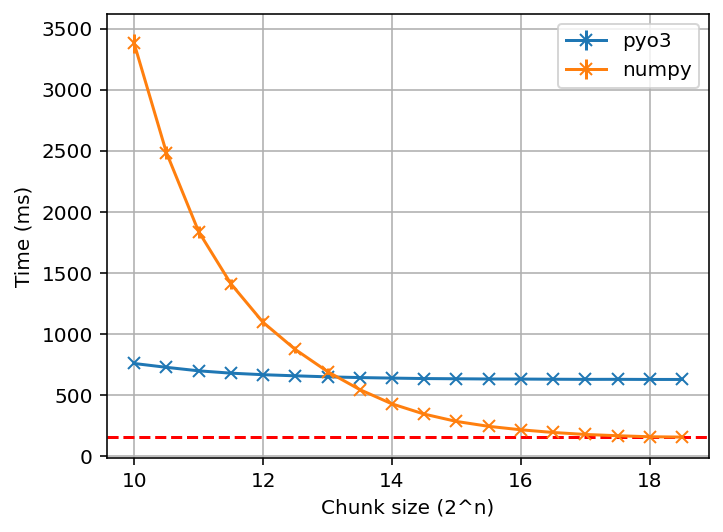

In [14]:
plt.figure(figsize=(len(umean['numpy']['x'])*0.3, 4), dpi=144)
plt.grid(True)

plt.yticks(np.arange(0, 5000, 500))
#plt.xticks(alabels)
for name, args in umean.items():
    plt.errorbar(x=mlabels, y=args['y'], yerr=args['yerr'], fmt='x-', label=name)
npr = min(umean['numpy']['y'])
plt.axhline(npr, linestyle='--', color="red")

plt.xlabel('Chunk size (2^n)')
plt.ylabel('Time (ms)')
plt.legend()
plt.savefig('plots/mean.png')
plt.show()

In [6]:
print('chunked mean')
print(",\n".join(
    make_row(f"{k:.3}", (get_measures(umean[m])[i] for m in ('pyo3', 'numpy'))) for i, k in enumerate(mlabels)
))

chunked mean
[ 10.0 ], [ 756.3 $plus.minus$ 4.875 ], [ 3.379e+03 $plus.minus$ 75.27 ],
[ 10.5 ], [ 724.8 $plus.minus$ 4.804 ], [ 2.485e+03 $plus.minus$ 52.54 ],
[ 11.0 ], [ 696.2 $plus.minus$ 4.422 ], [ 1.837e+03 $plus.minus$ 49.15 ],
[ 11.5 ], [ 677.0 $plus.minus$ 3.312 ], [ 1.41e+03 $plus.minus$ 41.39 ],
[ 12.0 ], [ 664.4 $plus.minus$ 4.021 ], [ 1.093e+03 $plus.minus$ 32.01 ],
[ 12.5 ], [ 655.3 $plus.minus$ 4.968 ], [ 870.9 $plus.minus$ 28.33 ],
[ 13.0 ], [ 647.0 $plus.minus$ 3.948 ], [ 690.0 $plus.minus$ 27.48 ],
[ 13.5 ], [ 640.9 $plus.minus$ 3.474 ], [ 542.6 $plus.minus$ 11.3 ],
[ 14.0 ], [ 636.6 $plus.minus$ 3.935 ], [ 425.3 $plus.minus$ 9.55 ],
[ 14.5 ], [ 632.8 $plus.minus$ 2.968 ], [ 341.6 $plus.minus$ 5.114 ],
[ 15.0 ], [ 631.1 $plus.minus$ 3.553 ], [ 281.5 $plus.minus$ 3.893 ],
[ 15.5 ], [ 629.3 $plus.minus$ 2.335 ], [ 241.3 $plus.minus$ 4.342 ],
[ 16.0 ], [ 628.7 $plus.minus$ 2.719 ], [ 213.1 $plus.minus$ 2.636 ],
[ 16.5 ], [ 627.3 $plus.minus$ 2.839 ], [ 191.1 $plus.minus$

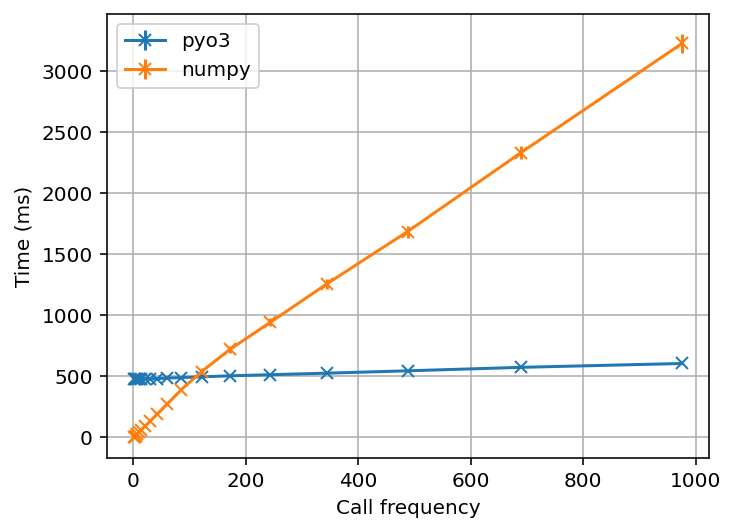

[np.float64(75.26971574266919), np.float64(52.53889622107502), np.float64(49.149426004164994), np.float64(41.39118064812304), np.float64(32.01030818318096), np.float64(28.328082202511023), np.float64(27.47958543323065), np.float64(11.301467309110306), np.float64(9.550192832026422), np.float64(5.11394938922508), np.float64(3.892897738902931), np.float64(4.342422194531014), np.float64(2.635906814235538), np.float64(3.100911634593212), np.float64(2.219531397239816), np.float64(1.6192380224455383), np.float64(3.264276581418921), np.float64(2.8252210839743737)]


In [15]:
plt.figure(figsize=(len(umean['numpy']['x'])*0.3, 4), dpi=144)
plt.grid(True)

imlabels = [int(1_000_000/2**v) for v in mlabels]
plt.yticks(np.arange(0, 5000, 500))
#plt.xticks(ialabels)
for name, args in umean.items():
    plt.errorbar(x=imlabels, y=args['y'] - npr, yerr=args['yerr'], fmt='x-', label=name)

plt.xlabel('Call frequency')
plt.ylabel('Time (ms)')
plt.legend()
plt.savefig('plots/add_mean.png')
plt.show()
print(max(m['yerr'] for m in umean.values()))

In [8]:
for name, args in umean.items():
    p, V = np.polyfit(imlabels, args['y'] - npr, 1, w=1/np.sqrt(args['yerr']), cov=True)
    V = np.sqrt(V)
    print(make_row(name, ((p[0], V[0][0]), (p[1], V[1][1]))))

[ pyo3 ], [ 0.1384 $plus.minus$ 0.00231 ], [ 473.9 $plus.minus$ 0.6433 ]
[ numpy ], [ 3.469 $plus.minus$ 0.07923 ], [ 10.1 $plus.minus$ 7.914 ]


/tmp/ipykernel_10676/3047004497.py:3: RuntimeWarning: invalid value encountered in sqrt
  V = np.sqrt(V)


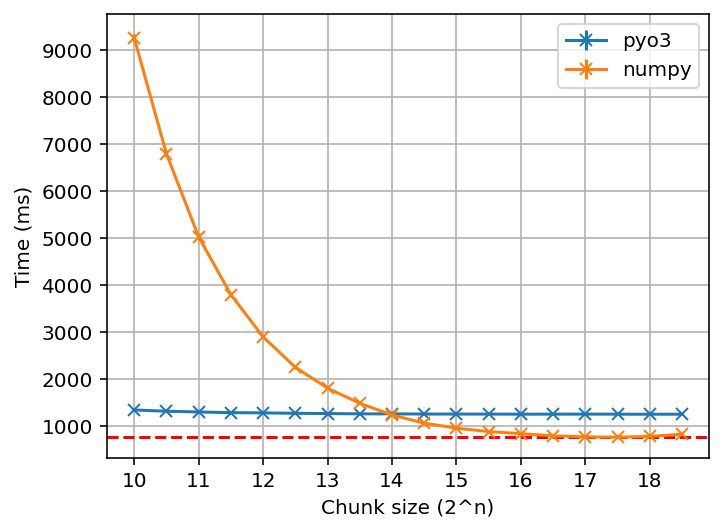

In [16]:
plt.figure(figsize=(len(umean['numpy']['x'])*0.3, 4), dpi=144)
plt.grid(True)

spr = min(ustd['numpy']['y'])
plt.yticks(np.arange(0, 10000, 1000))
plt.xticks(alabels)
for name, args in ustd.items():
    plt.errorbar(x=mlabels, y=args['y'], yerr=args['yerr'], fmt='x-', label=name)
plt.axhline(spr, linestyle='--', color="red")

plt.xlabel('Chunk size (2^n)')
plt.ylabel('Time (ms)')
plt.legend()
plt.savefig('plots/std.png')
plt.show()

In [10]:
print('chunked std')
print(",\n".join(
    make_row(f"{k:.3}", (get_measures(ustd[m])[i] for m in ('pyo3', 'numpy'))) for i, k in enumerate(mlabels)
))

chunked std
[ 10.0 ], [ 1.339e+03 $plus.minus$ 7.266 ], [ 9.258e+03 $plus.minus$ 74.2 ],
[ 10.5 ], [ 1.312e+03 $plus.minus$ 5.833 ], [ 6.795e+03 $plus.minus$ 69.84 ],
[ 11.0 ], [ 1.297e+03 $plus.minus$ 5.962 ], [ 5.024e+03 $plus.minus$ 77.34 ],
[ 11.5 ], [ 1.282e+03 $plus.minus$ 5.663 ], [ 3.794e+03 $plus.minus$ 52.87 ],
[ 12.0 ], [ 1.277e+03 $plus.minus$ 5.255 ], [ 2.895e+03 $plus.minus$ 27.89 ],
[ 12.5 ], [ 1.268e+03 $plus.minus$ 4.921 ], [ 2.248e+03 $plus.minus$ 29.99 ],
[ 13.0 ], [ 1.263e+03 $plus.minus$ 6.682 ], [ 1.803e+03 $plus.minus$ 22.13 ],
[ 13.5 ], [ 1.256e+03 $plus.minus$ 5.448 ], [ 1.481e+03 $plus.minus$ 13.5 ],
[ 14.0 ], [ 1.256e+03 $plus.minus$ 5.861 ], [ 1.232e+03 $plus.minus$ 12.55 ],
[ 14.5 ], [ 1.252e+03 $plus.minus$ 3.934 ], [ 1.058e+03 $plus.minus$ 11.2 ],
[ 15.0 ], [ 1.251e+03 $plus.minus$ 4.63 ], [ 951.5 $plus.minus$ 8.82 ],
[ 15.5 ], [ 1.251e+03 $plus.minus$ 3.864 ], [ 878.8 $plus.minus$ 6.618 ],
[ 16.0 ], [ 1.249e+03 $plus.minus$ 3.931 ], [ 834.8 $plus.minus$ 

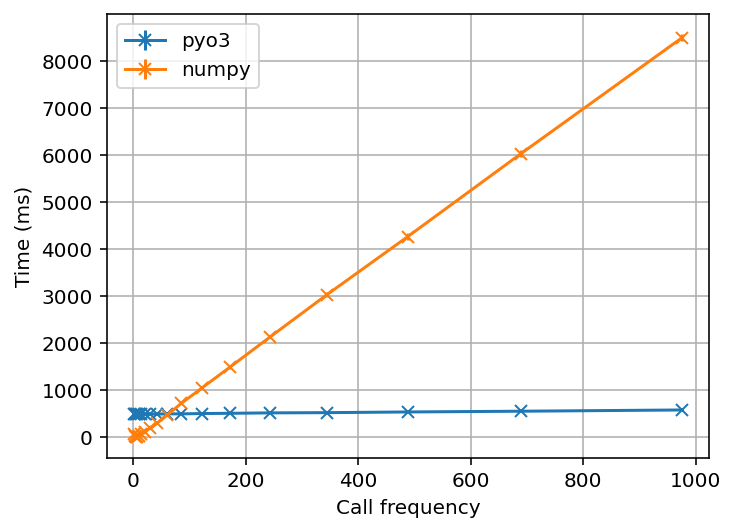

In [17]:
plt.figure(figsize=(len(ustd['numpy']['x'])*0.3, 4), dpi=144)
plt.grid(True)

plt.yticks(np.arange(0, 10000, 1000))
for name, args in ustd.items():
    plt.errorbar(x=imlabels, y=args['y'] - spr, yerr=args['yerr'], fmt='x-', label=name)

plt.xlabel('Call frequency')
plt.ylabel('Time (ms)')
plt.legend()
plt.savefig('plots/add_std.png')
plt.show()

In [12]:
for name, args in ustd.items():
    p, V = np.polyfit(imlabels, args['y'] - npr, 1, w=1/np.sqrt(args['yerr']), cov=True)
    V = np.sqrt(V)
    print(make_row(name, ((p[0], V[0][0]), (p[1], V[1][1]))))

[ pyo3 ], [ 0.09404 $plus.minus$ 0.001768 ], [ 1.096e+03 $plus.minus$ 0.4776 ]
[ numpy ], [ 8.802 $plus.minus$ 0.05657 ], [ 560.4 $plus.minus$ 8.121 ]


/tmp/ipykernel_10676/1348891480.py:3: RuntimeWarning: invalid value encountered in sqrt
  V = np.sqrt(V)
